# Makemore: Activation, Gradients, BatchNorm

- [Andrej Karpathy YouTube](https://www.youtube.com/watch?v=P6sfmUTpUmc&ab_channel=AndrejKarpathy)

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,torch,lightning --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
torch    : 2.2.2
lightning: 2.2.1

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

In [4]:
def load_data(file_path: str) -> list[str]:
    """Load text data from a file and return as a list of strings."""

    with open(file_path, "r") as f:
        # Read all the lines as a list
        data: list[str] = f.read().splitlines()

    return data

In [5]:
# Load Data
fp: str = "../../../data/names.txt"
names: list[str] = load_data(file_path=fp)

names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

### Build Vocabulary Of Characters And Mappings

In [6]:
special_token: str = "."
characters: list[str] = sorted(set("".join(names)))
# Add the special token to the beginning of the list.
characters.insert(0, special_token)
n_chars: int = len(characters)

# Convert text to numbers.
text_to_num: dict[str, int] = {text: idx for idx, text in enumerate(characters)}
# Convert numbers to text
num_to_text: dict[int, str] = {idx: text for text, idx in text_to_num.items()}

In [7]:
from torch.utils.data import random_split, TensorDataset, Dataset
from sklearn.model_selection import train_test_split


def build_dataset(
    names: list[str],
    special_token: str = ".",
    block_size: int = 3,
    print_info: bool = False,
) -> tuple[Tensor, Tensor]:
    """
    Builds a dataset of name sequences and their corresponding character indices.

    Args:
        names (list[str]): A list of names to build the dataset from.
        special_token (str, optional): A special token to append to the end of each name. Defaults to ".".
        block_size (int, optional): The size of the context window for each input sequence. Defaults to 3.
        print_info (bool, optional): Whether to print information about the dataset generation. Defaults to False.

    Returns:
        tuple[Tensor, Tensor]: A tuple containing the input sequences (X) and their corresponding target indices (Y).
    """
    X, Y = [], []

    for w in names:
        if print_info:
            print(w)
        context: list[str] = [0] * block_size

        for ch in w + special_token:
            ix: int = text_to_num.get(ch)
            X.append(context)
            Y.append(ix)

            if print_info:
                print(
                    f"{''.join([num_to_text.get(i) for i in context])} ---> {num_to_text.get(ix)}"
                )

            # Crop and append, like a rolling window
            context = context[1:] + [ix]

    X: Tensor = torch.tensor(X)
    Y: Tensor = torch.tensor(Y)
    print(f"\n{X.shape=}, {Y.shape=}")
    return (X, Y)


def split_data_into_train_dev_test(
    data: Tensor | Dataset, test_size: float = 0.05, dev_size: float = 0.1, seed=42
) -> tuple[Tensor, ...]:
    """
    Splits a given PyTorch tensor `data` into training, development, and test sets.

    Params:
    -------
        data (torch.Tensor): The input tensor to be split.
        test_size (float, optional): The fraction of the data to use for the test set. Defaults to 0.2.
        dev_size (float, optional): The fraction of the data to use for the development set. Defaults to 0.1.
        seed (int, optional): The random seed to use for reproducibility. Defaults to 42.

    Returns:
    --------
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]: The training, development, and test sets as PyTorch tensors.
    """
    if isinstance(data, Tensor):
        X_train, X_test = train_test_split(data, test_size=test_size, random_state=seed)
        X_train, X_dev = train_test_split(
            X_train, test_size=dev_size, random_state=seed
        )
        result: tuple[Tensor, ...] = (X_train, X_dev, X_test)
    if isinstance(data, Dataset):
        X_train, X_test, y_train, y_test = train_test_split(
            data.data,
            data.targets,
            test_size=test_size,
            random_state=seed,
            stratify=data.targets,
        )
        X_train, X_dev, y_train, y_dev = train_test_split(
            X_train, y_train, test_size=dev_size, random_state=seed, stratify=y_train
        )
        result: tuple[Tensor, ...] = (X_train, X_dev, X_test, y_train, y_dev, y_test)

    print(f"{X_train.shape=}; {X_dev.shape=}; {X_test.shape=}")

    return result


class MyDataset(Dataset):
    def __init__(self, data: Tensor, targets: Tensor) -> None:
        self.data = data
        self.targets = targets

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}(data.shape={self.data.shape}, "
            f"target.shape={self.targets.shape=})"
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y

In [8]:
X, y = build_dataset(names=names[:5], block_size=3, print_info=True)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .

X.shape=torch.Size([32, 3]), Y.shape=torch.Size([32])


### MLP

In [ ]:
X, y = build_dataset(names=names, block_size=3, print_info=False)
data: Dataset = MyDataset(X, y)

X_train, X_dev, X_test, y_train, y_dev, y_test = split_data_into_train_dev_test(
    data=data
)


X.shape=torch.Size([228152, 3]), Y.shape=torch.Size([228152])
X_train.shape=torch.Size([195069, 3]); X_dev.shape=torch.Size([21675, 3]); X_test.shape=torch.Size([11408, 3])


In [10]:
g = torch.Generator().manual_seed(5)

# Parameters
emb_dim: int = 10  # embedding dimension
block_size: int = 3  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 300  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 100_000  # number of epochs
C: Tensor = torch.randn((n_chars, emb_dim), generator=g)
W1: Tensor = torch.randn((M, n_nodes), generator=g)
b1: Tensor = torch.randn(n_nodes, generator=g)
W2: Tensor = torch.randn(n_nodes, n_chars, generator=g)  # (100, 27)
b2: Tensor = torch.randn(n_chars, generator=g)  # (27,)
print(f"{C.shape = }")
parameters: list[Tensor] = [C, W1, b1, W2, b2]
n_parameters: int = sum([p.nelement() for p in parameters])

# Require gradients to be true
for p in parameters:
    p.requires_grad = True

print(f"{n_parameters = :,}")

C.shape = torch.Size([27, 10])
n_parameters = 17,697


In [11]:
# Use The optimal learning rate to train the model
losses_all: list[float] = []

for epoch in range(epochs):

    # Add mini-batches
    idx: Tensor = torch.randint(0, X_train.shape[0], size=(batch_size,))

    # Step 1: Build an embedding lookup table
    # Embed the input
    emb: Tensor = F.one_hot(X_train[idx], num_classes=n_chars).float() @ C

    # Forward pass
    # Step 2: Build The Hidden Layer
    # Reshape the input to match the shape of the weight matrix
    h: Tensor = emb.view(-1, M) @ W1 + b1
    # Apply a non-linearity
    h = torch.tanh(h)

    # Step 3: Output Layer
    logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

    # Calculate the loss: Negative log likelihood loss
    loss: Tensor = F.cross_entropy(logits, y_train[idx])

    # Backward pass
    # Reset gradients
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    if epoch > 70_000:
        learning_rate = 0.01
    elif epoch > 80_000:
        learning_rate = 0.001

    # Update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

    # Record the loss
    losses_all.append(loss.item())

    if (epoch) % 10_000 == 0:
        print(f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.4f}")

Epoch: 0/100000 | Loss: 31.6660
Epoch: 10000/100000 | Loss: 2.7711
Epoch: 20000/100000 | Loss: 2.7740
Epoch: 30000/100000 | Loss: 2.4333
Epoch: 40000/100000 | Loss: 2.6319
Epoch: 50000/100000 | Loss: 2.5526
Epoch: 60000/100000 | Loss: 2.1652
Epoch: 70000/100000 | Loss: 2.5297
Epoch: 80000/100000 | Loss: 2.2590
Epoch: 90000/100000 | Loss: 1.7072


In [12]:
def calculate_loss(X: Tensor, y: Tensor, num_classes: int, training: True) -> Tensor:
    """
    Calculates the loss for the given input data and number of classes.

    Args:
        data (torch.Tensor): The input data tensor.
        num_classes (int): The number of classes.

    Returns:
        torch.Tensor: The calculated loss.
    """
    with torch.no_grad():
        input: Tensor = F.one_hot(X, num_classes=num_classes).float()
        emb: Tensor = torch.matmul(input, C)
        h: Tensor = torch.matmul(emb.view(-1, M), W1) + b1
        h = torch.tanh(h)
        logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

        loss: Tensor = F.cross_entropy(logits, y)
        result: str = (
            f"Training loss: {loss:.4f}" if training else f"Validation loss: {loss:.4f}"
        )
        print(result)

        return loss

In [13]:
calculate_loss(X=X_train, y=y_train, num_classes=n_chars, training=True)
calculate_loss(X=X_dev, y=y_dev, num_classes=n_chars, training=False)

Training loss: 2.1315
Validation loss: 2.1874


tensor(2.1874)

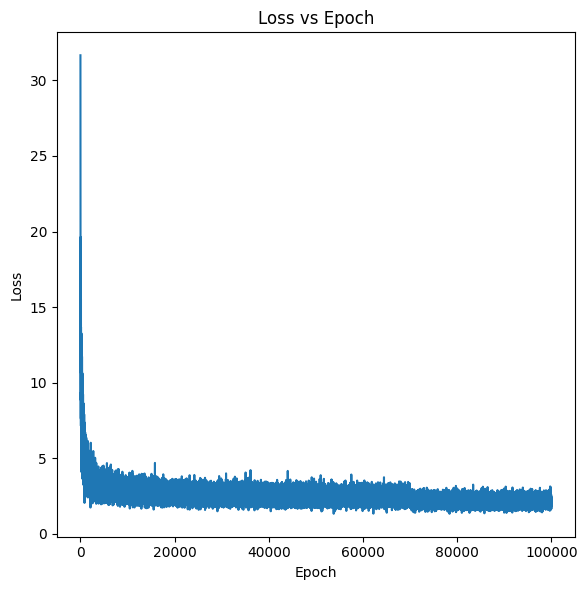

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))  # Create figure and axes
ax.plot(torch.arange(epochs), losses_all)  # Plot the data
ax.set(xlabel="Epoch", ylabel="Loss", title="Loss vs Epoch")  # Add labels
plt.tight_layout()
plt.show()

#### Comment:

- From the plot, we can see that the initial loss is way to high compared to the subsequent losses. i.e. 31.67, 2.8, etc.
- This is because of the way the modl weights were initialized.
- To solve this problem, we can:
  1. Initialize the weights with numbers that are very close to zero.
  2. Initialize the bias with zeros.
- This makes the loss very close to the subsequent losses.
- e.g. if the prob of selecting a char at random is 1 / n_chars, the negative log likelihood is:
$$  loss = -1 * log(\frac{1}{n_{chars}})  $$

- The plot of the loss vs epochs should `not` have a golf curve.

In [20]:
-1 * torch.tensor([1 / n_chars]).log()

tensor([3.2958])

In [15]:
X, y = build_dataset(names=names, block_size=3, print_info=False)
data: Dataset = MyDataset(X, y)

X_train, X_dev, X_test, y_train, y_dev, y_test = split_data_into_train_dev_test(
    data=data
)


X.shape=torch.Size([228152, 3]), Y.shape=torch.Size([228152])
X_train.shape=torch.Size([195069, 3]); X_dev.shape=torch.Size([21675, 3]); X_test.shape=torch.Size([11408, 3])


In [16]:
g = torch.Generator().manual_seed(5)

# Parameters
emb_dim: int = 10  # embedding dimension
block_size: int = 3  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 300  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 100_000  # number of epochs
C: Tensor = torch.randn((n_chars, emb_dim), generator=g)
W1: Tensor = torch.randn((M, n_nodes), generator=g)
b1: Tensor = torch.randn(n_nodes, generator=g)
# Initialize the weights and biases with very small random values.
W2: Tensor = torch.randn(n_nodes, n_chars, generator=g) * 0.01  # (100, 27)
b2: Tensor = torch.randn(n_chars, generator=g) * 0  # (27,)
print(f"{C.shape = }")
parameters: list[Tensor] = [C, W1, b1, W2, b2]
n_parameters: int = sum([p.nelement() for p in parameters])

# Require gradients to be true
for p in parameters:
    p.requires_grad = True

print(f"{n_parameters = :,}")

C.shape = torch.Size([27, 10])
n_parameters = 17,697


In [17]:
# Use The optimal learning rate to train the model
losses_all: list[float] = []

for epoch in range(epochs):

    # Add mini-batches
    idx: Tensor = torch.randint(0, X_train.shape[0], size=(batch_size,))

    # Step 1: Build an embedding lookup table
    # Embed the input
    emb: Tensor = F.one_hot(X_train[idx], num_classes=n_chars).float() @ C

    # Forward pass
    # Step 2: Build The Hidden Layer
    # Reshape the input to match the shape of the weight matrix
    h: Tensor = emb.view(-1, M) @ W1 + b1
    # Apply a non-linearity
    h = torch.tanh(h)

    # Step 3: Output Layer
    logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

    # Calculate the loss: Negative log likelihood loss
    loss: Tensor = F.cross_entropy(logits, y_train[idx])

    # Backward pass
    # Reset gradients
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    if epoch > 70_000:
        learning_rate = 0.01
    elif epoch > 80_000:
        learning_rate = 0.001

    # Update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

    # Record the loss
    losses_all.append(loss.item())

    if (epoch) % 10_000 == 0:
        print(f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.4f}")

Epoch: 0/100000 | Loss: 3.3133
Epoch: 10000/100000 | Loss: 2.2706
Epoch: 20000/100000 | Loss: 1.9573
Epoch: 30000/100000 | Loss: 2.4691
Epoch: 40000/100000 | Loss: 2.3424
Epoch: 50000/100000 | Loss: 2.2080
Epoch: 60000/100000 | Loss: 2.2763
Epoch: 70000/100000 | Loss: 2.1133
Epoch: 80000/100000 | Loss: 1.5924
Epoch: 90000/100000 | Loss: 2.0571


In [ ]:
calculate_loss(X=X_train, y=y_train, num_classes=n_chars, training=True)
calculate_loss(X=X_dev, y=y_dev, num_classes=n_chars, training=False)

Training loss: 2.1315
Validation loss: 2.1874


tensor(2.1874)

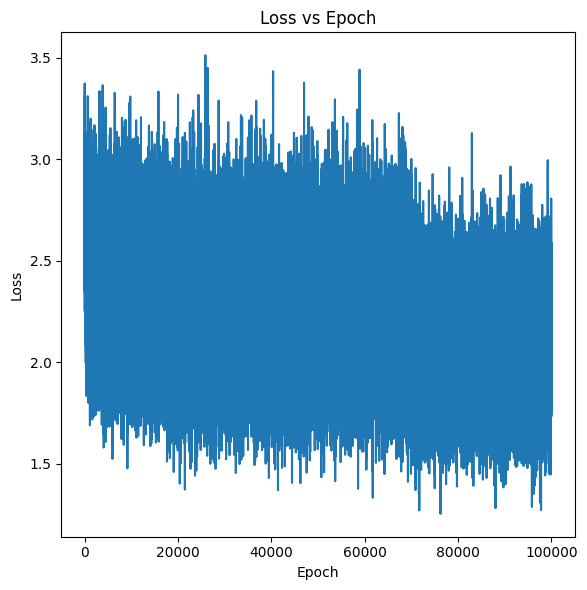

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))  # Create figure and axes
ax.plot(torch.arange(epochs), losses_all)  # Plot the data
ax.set(xlabel="Epoch", ylabel="Loss", title="Loss vs Epoch")  # Add labels
plt.tight_layout()
plt.show()

In [23]:
h.shape

torch.Size([32, 300])

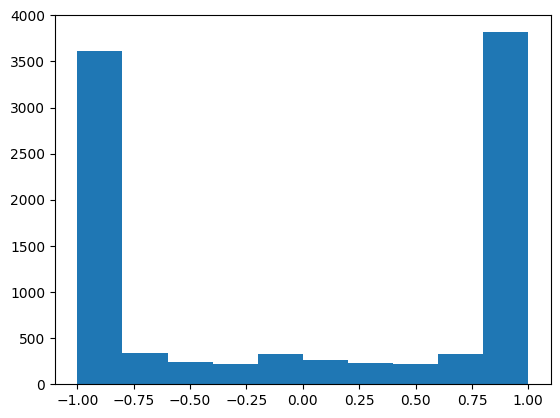

In [26]:
# Convert to a 1-D tensor
plt.hist(h.view(-1).tolist())
plt.show()

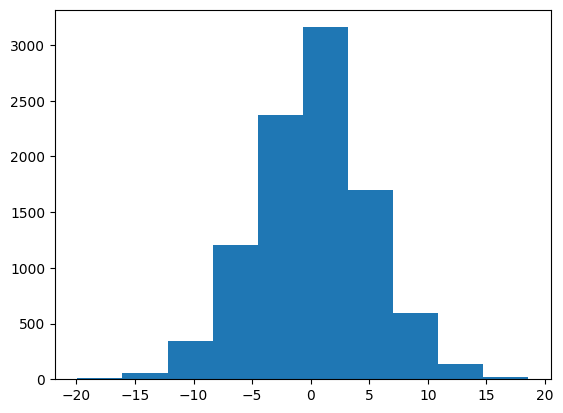

In [27]:
h_before_tanh: Tensor = emb.view(-1, M) @ W1 + b1
# Convert to a 1-D tensor
plt.hist(h_before_tanh.view(-1).tolist())
plt.show()

#### Comment

- For `h`, we can see that the activation function is strong. i.e. most values are between -1 and 1.
- For `h_before_tanh`, we can see that there's `NO` activation function and the values are normally distributed.